In [1]:
import numpy as np
import zipfile
from datasets import Dataset
import pandas as pd

import os
# run as much as possible accelerated by apple silicon, fall back to cpu if not possible
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch

import sys
sys.path.append('..')
from scripts.audio import audio_file_to_array
from scripts.ipa import timit2ipa

/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys, os
sys.path.append('..')
from scripts.eval_tests.panphon_model_eval import panphon_model_eval 

In [3]:
# set espeak library path for macOS
if sys.platform == "darwin":
    from phonemizer.backend.espeak.wrapper import EspeakWrapper

    _ESPEAK_LIBRARY = "/opt/homebrew/Cellar/espeak/1.48.04_1/lib/libespeak.1.1.48.dylib"
    EspeakWrapper.set_library(_ESPEAK_LIBRARY)

In [4]:
from transformers import AutoProcessor, AutoModelForCTC, AutoTokenizer, AutoFeatureExtractor

In [5]:
PRE_TRAINED_ID = "facebook/wav2vec2-lv-60-espeak-cv-ft"

# Load Data

In [6]:
timit = zipfile.ZipFile('../.data/TIMIT.zip', 'r')
timit_files = timit.namelist()

In [7]:

test_files = list(set(map(lambda x: x.split('.')[0], filter(lambda x: x.startswith('data/TEST'), timit_files))))

In [8]:

def timit_file_to_dict(filename):
    with timit.open(filename + '.PHN') as phn_file:
        timestamped_phonemes = []
        for line in phn_file.read().decode('utf-8').split('\n'):
            if line == '':
                continue
            start, end, phoneme = line.split()
            timestamped_phonemes.append((timit2ipa(phoneme, "eng"), int(start), int(end)))
    return {'timestamped_phonemes': timestamped_phonemes, 'wav_filename': filename + '.WAV'}
    

In [9]:
WAV_HEADER_SIZE = 44
def zipped_wav_to_array(filename):
    with timit.open(filename) as wav_file:
        return np.frombuffer(wav_file.read(), dtype=np.int16)[WAV_HEADER_SIZE//2:]

In [10]:

parsed_0 = timit_file_to_dict(test_files[0])
print(parsed_0)

{'timestamped_phonemes': [('', 0, 2200), ('ə', 2200, 2680), ('b', 2680, 3720), ('', 3720, 4040), ('ɔ', 4040, 5263), ('ɹ', 5263, 6057), ('ɨ', 6057, 6684), ('ŋ', 6684, 7400), ('n', 7400, 8187), ('ɑ', 8187, 10945), ('v', 10945, 12120), ('l̩ ', 12120, 13827), ('ɨ', 13827, 15560), ('z', 15560, 16280), ('eɪ', 16280, 17800), ('s', 17800, 19640), ('ɨ', 19640, 20280), ('p', 20280, 21160), ('', 21160, 22360), ('ɝ', 22360, 25065), ('b', 25065, 26320), ('s', 26320, 28280), ('l', 28280, 28760), ('i', 28760, 29720), ('p', 29720, 31000), ('', 31000, 31373), ('ɨ', 31373, 31999), ('ŋ', 31999, 33320), ('p', 33320, 33880), ('', 33880, 34882), ('ɪ', 34882, 36804), ('l', 36804, 38892), ('', 38892, 42560)], 'wav_filename': 'data/TEST/DR3/MRTK0/SX373.WAV'}


In [11]:
def files_to_df(files):
    records = []
    for filename in files:
        parsed = timit_file_to_dict(filename)
        parsed['audio'] = zipped_wav_to_array(parsed['wav_filename'])
        del parsed['wav_filename']
        parsed['ipa'] = "".join(phoneme for phoneme, _, _ in parsed['timestamped_phonemes'])
        parsed['phoneme_starts'] = [start for _, start, _ in parsed['timestamped_phonemes']]
        parsed['phoneme_ends'] = [end for _, _, end in parsed['timestamped_phonemes']]
        del parsed['timestamped_phonemes']
        records.append(parsed)
    return pd.DataFrame(records)

In [12]:
test_df = files_to_df(test_files)
test_df.head()

,audio,ipa,phoneme_starts,phoneme_ends
0,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",əbɔɹɨŋnɑvl̩ ɨzeɪsɨpɝbslipɨŋpɪl,"[0, 2200, 2680, 3720, 4040, 5263, 6057, 6684, ...","[2200, 2680, 3720, 4040, 5263, 6057, 6684, 740..."
1,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʊtðəbʊttʃɚblɑkeɪbl̩ ənðɨɡɝɑʃ,"[0, 10760, 11630, 12574, 14430, 14670, 15200, ...","[10760, 11630, 12574, 14430, 14670, 15200, 163..."
2,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",waɪjɛlɚwɝioʊvɚsɪliaɪɾəms,"[0, 2240, 3174, 5597, 7185, 8313, 9232, 10276,...","[2240, 3174, 5597, 7185, 8313, 9232, 10276, 12..."
3,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",huɔθɚɹaɪzðiʌnlɪmɨɾɪdʔɨkspɛntsəkaʊnt,"[0, 2214, 2966, 4219, 6200, 7530, 7979, 8939, ...","[2214, 2966, 4219, 6200, 7530, 7979, 8939, 113..."
4,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ðəmɨskwoʊtwəzɹitɹækɨdwəθɛnəpɑləddʒɨ,"[0, 2320, 2622, 3007, 4245, 5077, 6266, 7180, ...","[2320, 2622, 3007, 4245, 5077, 6266, 7180, 824..."


### Cleaning Up Audio

In [13]:
def crop_audio(row):
    # Access the phoneme_starts column and get the last value of the list
    end = row['phoneme_starts'][-1]
    # Access the phoneme_ends column and get the first value of the list
    start = row['phoneme_ends'][0]
    # Crop the audio from start to end
    # note that start and end are in samples, not seconds
    cropped_audio = row['audio'][start:end]
    
    return cropped_audio

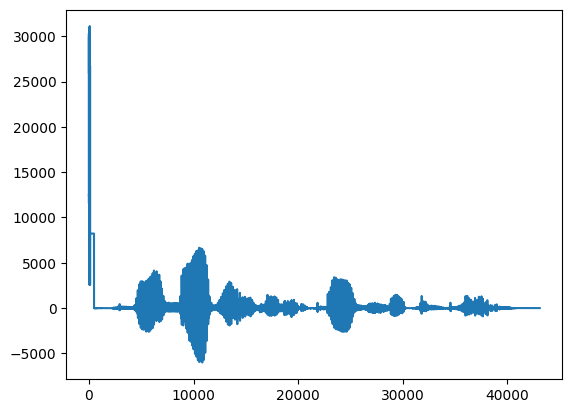

In [14]:
# graph one audio to see start signal that we will remove
import matplotlib.pyplot as plt
plt.plot(test_df['audio'][0])
plt.show()

In [15]:
test_df['cropped_audio'] = test_df.apply(crop_audio, axis=1)
test_df.head()

,audio,ipa,phoneme_starts,phoneme_ends,cropped_audio
0,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",əbɔɹɨŋnɑvl̩ ɨzeɪsɨpɝbslipɨŋpɪl,"[0, 2200, 2680, 3720, 4040, 5263, 6057, 6684, ...","[2200, 2680, 3720, 4040, 5263, 6057, 6684, 740...","[-3, -3, 0, 3, -2, 0, 5, 5, 9, 8, 1, 2, 0, 1, ..."
1,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʊtðəbʊttʃɚblɑkeɪbl̩ ənðɨɡɝɑʃ,"[0, 10760, 11630, 12574, 14430, 14670, 15200, ...","[10760, 11630, 12574, 14430, 14670, 15200, 163...","[3, 4, 4, 2, 0, 5, -1, 3, 5, 2, 3, 4, 3, 2, 3,..."
2,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",waɪjɛlɚwɝioʊvɚsɪliaɪɾəms,"[0, 2240, 3174, 5597, 7185, 8313, 9232, 10276,...","[2240, 3174, 5597, 7185, 8313, 9232, 10276, 12...","[-11, -8, -9, -8, -4, 10, 4, 12, 13, 20, 14, 1..."
3,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",huɔθɚɹaɪzðiʌnlɪmɨɾɪdʔɨkspɛntsəkaʊnt,"[0, 2214, 2966, 4219, 6200, 7530, 7979, 8939, ...","[2214, 2966, 4219, 6200, 7530, 7979, 8939, 113...","[27, 21, 6, 2, -14, -18, -19, -29, -24, -22, -..."
4,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ðəmɨskwoʊtwəzɹitɹækɨdwəθɛnəpɑləddʒɨ,"[0, 2320, 2622, 3007, 4245, 5077, 6266, 7180, ...","[2320, 2622, 3007, 4245, 5077, 6266, 7180, 824...","[3, 2, 2, 6, 1, 6, 0, 4, 3, 0, 2, 2, 0, 1, 6, ..."


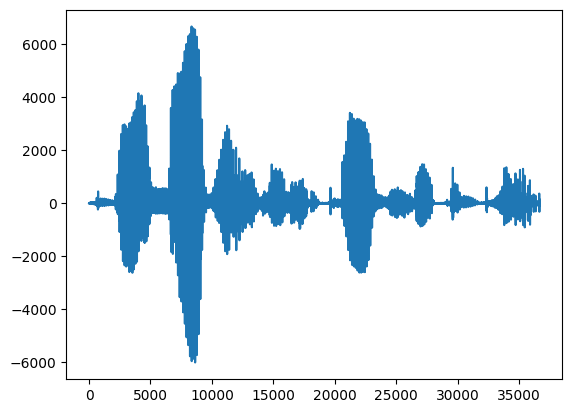

In [16]:
# visualize again, much better!
plt.plot(test_df['cropped_audio'][0])


In [17]:
# Same for test_df
test_df = test_df.drop(columns=['phoneme_starts', 'phoneme_ends', 'audio'])
test_df = test_df.rename(columns={'cropped_audio': 'audio'})
test_df.head()

,ipa,audio
0,əbɔɹɨŋnɑvl̩ ɨzeɪsɨpɝbslipɨŋpɪl,"[-3, -3, 0, 3, -2, 0, 5, 5, 9, 8, 1, 2, 0, 1, ..."
1,ʊtðəbʊttʃɚblɑkeɪbl̩ ənðɨɡɝɑʃ,"[3, 4, 4, 2, 0, 5, -1, 3, 5, 2, 3, 4, 3, 2, 3,..."
2,waɪjɛlɚwɝioʊvɚsɪliaɪɾəms,"[-11, -8, -9, -8, -4, 10, 4, 12, 13, 20, 14, 1..."
3,huɔθɚɹaɪzðiʌnlɪmɨɾɪdʔɨkspɛntsəkaʊnt,"[27, 21, 6, 2, -14, -18, -19, -29, -24, -22, -..."
4,ðəmɨskwoʊtwəzɹitɹækɨdwəθɛnəpɑləddʒɨ,"[3, 2, 2, 6, 1, 6, 0, 4, 3, 0, 2, 2, 0, 1, 6, ..."


In [18]:
print(test_df['ipa'][0])

əbɔɹɨŋnɑvl̩ ɨzeɪsɨpɝbslipɨŋpɪl


In [19]:

test_ds = Dataset.from_pandas(test_df)

# Tokenize!

In [20]:
timit_vocab = set("".join(test_df['ipa']))

In [21]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_ID)
vocab = tokenizer.get_vocab()
print(vocab)

{'<s>': 1, '<pad>': 0, '</s>': 2, '<unk>': 3, 'n': 4, 's': 5, 't': 6, 'ə': 7, 'l': 8, 'a': 9, 'i': 10, 'k': 11, 'd': 12, 'm': 13, 'ɛ': 14, 'ɾ': 15, 'e': 16, 'ɪ': 17, 'p': 18, 'o': 19, 'ɐ': 20, 'z': 21, 'ð': 22, 'f': 23, 'j': 24, 'v': 25, 'b': 26, 'ɹ': 27, 'ʁ': 28, 'ʊ': 29, 'iː': 30, 'r': 31, 'w': 32, 'ʌ': 33, 'u': 34, 'ɡ': 35, 'æ': 36, 'aɪ': 37, 'ʃ': 38, 'h': 39, 'ɔ': 40, 'ɑː': 41, 'ŋ': 42, 'ɚ': 43, 'eɪ': 44, 'β': 45, 'uː': 46, 'y': 47, 'ɑ̃': 48, 'oʊ': 49, 'ᵻ': 50, 'eː': 51, 'θ': 52, 'aʊ': 53, 'ts': 54, 'oː': 55, 'ɔ̃': 56, 'ɣ': 57, 'ɜ': 58, 'ɑ': 59, 'dʒ': 60, 'əl': 61, 'x': 62, 'ɜː': 63, 'ç': 64, 'ʒ': 65, 'tʃ': 66, 'ɔː': 67, 'ɑːɹ': 68, 'ɛ̃': 69, 'ʎ': 70, 'ɔːɹ': 71, 'ʋ': 72, 'aː': 73, 'ɕ': 74, 'œ': 75, 'ø': 76, 'oːɹ': 77, 'ɲ': 78, 'yː': 79, 'ʔ': 80, 'iə': 81, 'i5': 82, 's.': 83, 'tɕ': 84, '??': 85, 'nʲ': 86, 'ɛː': 87, 'œ̃': 88, 'ɭ': 89, 'ɔø': 90, 'ʑ': 91, 'tʲ': 92, 'ɨ': 93, 'ɛɹ': 94, 'ts.': 95, 'rʲ': 96, 'ɪɹ': 97, 'ɭʲ': 98, 'i.5': 99, 'ɔɪ': 100, 'q': 101, 'sʲ': 102, 'u5': 103, 'ʊɹ': 104

In [22]:
# Get current tokenizer vocabulary
current_vocab = set(tokenizer.get_vocab().keys())

# Define TIMIT phoneme vocabulary and manually added phonemes
additional_vocab = timit_vocab.difference(current_vocab | {' '})  # Remove phonemes already in the tokenizer
# Update: unfortunately this function fails to parse diphones so we will manually add them to the vocab: 
phonemes_to_add = {"aɪ", "aʊ", "dʒ", "eɪ", "l̩", "m̩", "n̩", "oʊ", "tʃ", "ŋ̍", "ɔɪ", "ə̥", "ɾ̃"}

# Combine the new phonemes, ensuring uniqueness
unique_additional_tokens = additional_vocab.union(phonemes_to_add).difference(current_vocab)

# Add the unique tokens to the tokenizer
if unique_additional_tokens:
    tokenizer.add_tokens(list(unique_additional_tokens))

# Print the tokens added for confirmation
print("Unique tokens added to the tokenizer:", unique_additional_tokens)


Unique tokens added to the tokenizer: {'̩', '̍', 'ɦ', 'ə̥', 'ɾ̃', '̥', 'ɝ', 'm̩', '̃', 'ŋ̍'}


In [25]:
tokenizer.add_tokens(list(unique_additional_tokens))
print(tokenizer.get_vocab())

{'<s>': 1, '<pad>': 0, '</s>': 2, '<unk>': 3, 'n': 4, 's': 5, 't': 6, 'ə': 7, 'l': 8, 'a': 9, 'i': 10, 'k': 11, 'd': 12, 'm': 13, 'ɛ': 14, 'ɾ': 15, 'e': 16, 'ɪ': 17, 'p': 18, 'o': 19, 'ɐ': 20, 'z': 21, 'ð': 22, 'f': 23, 'j': 24, 'v': 25, 'b': 26, 'ɹ': 27, 'ʁ': 28, 'ʊ': 29, 'iː': 30, 'r': 31, 'w': 32, 'ʌ': 33, 'u': 34, 'ɡ': 35, 'æ': 36, 'aɪ': 37, 'ʃ': 38, 'h': 39, 'ɔ': 40, 'ɑː': 41, 'ŋ': 42, 'ɚ': 43, 'eɪ': 44, 'β': 45, 'uː': 46, 'y': 47, 'ɑ̃': 48, 'oʊ': 49, 'ᵻ': 50, 'eː': 51, 'θ': 52, 'aʊ': 53, 'ts': 54, 'oː': 55, 'ɔ̃': 56, 'ɣ': 57, 'ɜ': 58, 'ɑ': 59, 'dʒ': 60, 'əl': 61, 'x': 62, 'ɜː': 63, 'ç': 64, 'ʒ': 65, 'tʃ': 66, 'ɔː': 67, 'ɑːɹ': 68, 'ɛ̃': 69, 'ʎ': 70, 'ɔːɹ': 71, 'ʋ': 72, 'aː': 73, 'ɕ': 74, 'œ': 75, 'ø': 76, 'oːɹ': 77, 'ɲ': 78, 'yː': 79, 'ʔ': 80, 'iə': 81, 'i5': 82, 's.': 83, 'tɕ': 84, '??': 85, 'nʲ': 86, 'ɛː': 87, 'œ̃': 88, 'ɭ': 89, 'ɔø': 90, 'ʑ': 91, 'tʲ': 92, 'ɨ': 93, 'ɛɹ': 94, 'ts.': 95, 'rʲ': 96, 'ɪɹ': 97, 'ɭʲ': 98, 'i.5': 99, 'ɔɪ': 100, 'q': 101, 'sʲ': 102, 'u5': 103, 'ʊɹ': 104

In [23]:
# replace ' ' in ipa with tokenizer.pad_token
test_ds = test_ds.map(lambda x: {'audio': x['audio'], 'ipa': x['ipa'].replace(' ', tokenizer.pad_token)})

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map: 100%|██████████| 1680/1680 [00:43<00:00, 39.05 examples/s]


# Update Feature Extraction

In [24]:
feature_extractor = AutoFeatureExtractor.from_pretrained(PRE_TRAINED_ID)

We don't need to update the feature extractor since it has been pretrained on 16kHz audio which matches the TIMIT dataset.

For datasets with different sampling rates, the feature extractor should be updated or the audio resampled (easier).

This is also where code to add extra features (such as conditioning on speaker's native language etc.) would be added.

# Save Updated Tokenizer

In [26]:
processor = AutoProcessor.from_pretrained(PRE_TRAINED_ID)
processor.tokenizer = tokenizer
print(processor.tokenizer.get_vocab())

{'<s>': 1, '<pad>': 0, '</s>': 2, '<unk>': 3, 'n': 4, 's': 5, 't': 6, 'ə': 7, 'l': 8, 'a': 9, 'i': 10, 'k': 11, 'd': 12, 'm': 13, 'ɛ': 14, 'ɾ': 15, 'e': 16, 'ɪ': 17, 'p': 18, 'o': 19, 'ɐ': 20, 'z': 21, 'ð': 22, 'f': 23, 'j': 24, 'v': 25, 'b': 26, 'ɹ': 27, 'ʁ': 28, 'ʊ': 29, 'iː': 30, 'r': 31, 'w': 32, 'ʌ': 33, 'u': 34, 'ɡ': 35, 'æ': 36, 'aɪ': 37, 'ʃ': 38, 'h': 39, 'ɔ': 40, 'ɑː': 41, 'ŋ': 42, 'ɚ': 43, 'eɪ': 44, 'β': 45, 'uː': 46, 'y': 47, 'ɑ̃': 48, 'oʊ': 49, 'ᵻ': 50, 'eː': 51, 'θ': 52, 'aʊ': 53, 'ts': 54, 'oː': 55, 'ɔ̃': 56, 'ɣ': 57, 'ɜ': 58, 'ɑ': 59, 'dʒ': 60, 'əl': 61, 'x': 62, 'ɜː': 63, 'ç': 64, 'ʒ': 65, 'tʃ': 66, 'ɔː': 67, 'ɑːɹ': 68, 'ɛ̃': 69, 'ʎ': 70, 'ɔːɹ': 71, 'ʋ': 72, 'aː': 73, 'ɕ': 74, 'œ': 75, 'ø': 76, 'oːɹ': 77, 'ɲ': 78, 'yː': 79, 'ʔ': 80, 'iə': 81, 'i5': 82, 's.': 83, 'tɕ': 84, '??': 85, 'nʲ': 86, 'ɛː': 87, 'œ̃': 88, 'ɭ': 89, 'ɔø': 90, 'ʑ': 91, 'tʲ': 92, 'ɨ': 93, 'ɛɹ': 94, 'ts.': 95, 'rʲ': 96, 'ɪɹ': 97, 'ɭʲ': 98, 'i.5': 99, 'ɔɪ': 100, 'q': 101, 'sʲ': 102, 'u5': 103, 'ʊɹ': 104

# Preprocess Data

In [26]:
vocab = processor.tokenizer.get_vocab()
print(vocab)

{'<s>': 1, '<pad>': 0, '</s>': 2, '<unk>': 3, 'n': 4, 's': 5, 't': 6, 'ə': 7, 'l': 8, 'a': 9, 'i': 10, 'k': 11, 'd': 12, 'm': 13, 'ɛ': 14, 'ɾ': 15, 'e': 16, 'ɪ': 17, 'p': 18, 'o': 19, 'ɐ': 20, 'z': 21, 'ð': 22, 'f': 23, 'j': 24, 'v': 25, 'b': 26, 'ɹ': 27, 'ʁ': 28, 'ʊ': 29, 'iː': 30, 'r': 31, 'w': 32, 'ʌ': 33, 'u': 34, 'ɡ': 35, 'æ': 36, 'aɪ': 37, 'ʃ': 38, 'h': 39, 'ɔ': 40, 'ɑː': 41, 'ŋ': 42, 'ɚ': 43, 'eɪ': 44, 'β': 45, 'uː': 46, 'y': 47, 'ɑ̃': 48, 'oʊ': 49, 'ᵻ': 50, 'eː': 51, 'θ': 52, 'aʊ': 53, 'ts': 54, 'oː': 55, 'ɔ̃': 56, 'ɣ': 57, 'ɜ': 58, 'ɑ': 59, 'dʒ': 60, 'əl': 61, 'x': 62, 'ɜː': 63, 'ç': 64, 'ʒ': 65, 'tʃ': 66, 'ɔː': 67, 'ɑːɹ': 68, 'ɛ̃': 69, 'ʎ': 70, 'ɔːɹ': 71, 'ʋ': 72, 'aː': 73, 'ɕ': 74, 'œ': 75, 'ø': 76, 'oːɹ': 77, 'ɲ': 78, 'yː': 79, 'ʔ': 80, 'iə': 81, 'i5': 82, 's.': 83, 'tɕ': 84, '??': 85, 'nʲ': 86, 'ɛː': 87, 'œ̃': 88, 'ɭ': 89, 'ɔø': 90, 'ʑ': 91, 'tʲ': 92, 'ɨ': 93, 'ɛɹ': 94, 'ts.': 95, 'rʲ': 96, 'ɪɹ': 97, 'ɭʲ': 98, 'i.5': 99, 'ɔɪ': 100, 'q': 101, 'sʲ': 102, 'u5': 103, 'ʊɹ': 104

In [27]:
def prepare_dataset(batch):
    batch["input_values"] = processor(batch["audio"], sampling_rate=feature_extractor.sampling_rate).input_values
    with processor.as_target_processor():
        batch["labels"] = processor(batch["ipa"]).input_ids

    return batch

In [28]:
test_df.head()

,ipa,audio
0,əbɔɹɨŋnɑvl̩ ɨzeɪsɨpɝbslipɨŋpɪl,"[-3, -3, 0, 3, -2, 0, 5, 5, 9, 8, 1, 2, 0, 1, ..."
1,ʊtðəbʊttʃɚblɑkeɪbl̩ ənðɨɡɝɑʃ,"[3, 4, 4, 2, 0, 5, -1, 3, 5, 2, 3, 4, 3, 2, 3,..."
2,waɪjɛlɚwɝioʊvɚsɪliaɪɾəms,"[-11, -8, -9, -8, -4, 10, 4, 12, 13, 20, 14, 1..."
3,huɔθɚɹaɪzðiʌnlɪmɨɾɪdʔɨkspɛntsəkaʊnt,"[27, 21, 6, 2, -14, -18, -19, -29, -24, -22, -..."
4,ðəmɨskwoʊtwəzɹitɹækɨdwəθɛnəpɑləddʒɨ,"[3, 2, 2, 6, 1, 6, 0, 4, 3, 0, 2, 2, 0, 1, 6, ..."


In [29]:
# test prepare_dataset on just the furst row of the train_ds

ds_test = prepare_dataset(test_ds[0])
# remove the audio and ipa from the dataset for now
ds_test.pop('audio')
ds_test.pop('ipa')



NameError: name 'feature_extractor' is not defined

In [30]:
# test_ds = test_ds.map(prepare_dataset, batched=True, remove_columns=test_ds.column_names)

# Fine-Tune Model

In [30]:
vocab = processor.tokenizer.get_vocab()
print(vocab)


{'<s>': 1, '<pad>': 0, '</s>': 2, '<unk>': 3, 'n': 4, 's': 5, 't': 6, 'ə': 7, 'l': 8, 'a': 9, 'i': 10, 'k': 11, 'd': 12, 'm': 13, 'ɛ': 14, 'ɾ': 15, 'e': 16, 'ɪ': 17, 'p': 18, 'o': 19, 'ɐ': 20, 'z': 21, 'ð': 22, 'f': 23, 'j': 24, 'v': 25, 'b': 26, 'ɹ': 27, 'ʁ': 28, 'ʊ': 29, 'iː': 30, 'r': 31, 'w': 32, 'ʌ': 33, 'u': 34, 'ɡ': 35, 'æ': 36, 'aɪ': 37, 'ʃ': 38, 'h': 39, 'ɔ': 40, 'ɑː': 41, 'ŋ': 42, 'ɚ': 43, 'eɪ': 44, 'β': 45, 'uː': 46, 'y': 47, 'ɑ̃': 48, 'oʊ': 49, 'ᵻ': 50, 'eː': 51, 'θ': 52, 'aʊ': 53, 'ts': 54, 'oː': 55, 'ɔ̃': 56, 'ɣ': 57, 'ɜ': 58, 'ɑ': 59, 'dʒ': 60, 'əl': 61, 'x': 62, 'ɜː': 63, 'ç': 64, 'ʒ': 65, 'tʃ': 66, 'ɔː': 67, 'ɑːɹ': 68, 'ɛ̃': 69, 'ʎ': 70, 'ɔːɹ': 71, 'ʋ': 72, 'aː': 73, 'ɕ': 74, 'œ': 75, 'ø': 76, 'oːɹ': 77, 'ɲ': 78, 'yː': 79, 'ʔ': 80, 'iə': 81, 'i5': 82, 's.': 83, 'tɕ': 84, '??': 85, 'nʲ': 86, 'ɛː': 87, 'œ̃': 88, 'ɭ': 89, 'ɔø': 90, 'ʑ': 91, 'tʲ': 92, 'ɨ': 93, 'ɛɹ': 94, 'ts.': 95, 'rʲ': 96, 'ɪɹ': 97, 'ɭʲ': 98, 'i.5': 99, 'ɔɪ': 100, 'q': 101, 'sʲ': 102, 'u5': 103, 'ʊɹ': 104

In [31]:

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False) # labels are already grouped as they should be

    # Call panphon_model_eval with label and predictedipa
    results = panphon_model_eval(label_str, pred_str)

    # Output results
    print("Evaluation Results:")
    print(f"Feature edit distance: {results['feature_dist']}")
    print(f"Weighted feature edit distance: {results['weighted_feature_dist']}")
    print(f"Hamming distance: {results['hamming_feature_dist']}")
    print(f"CER: {results['cer_score']}")


    return results

In [32]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


# Load processor and model
PRE_TRAINED_ID = "facebook/wav2vec2-lv-60-espeak-cv-ft"
processor = Wav2Vec2Processor.from_pretrained(PRE_TRAINED_ID)
model = Wav2Vec2ForCTC.from_pretrained(PRE_TRAINED_ID)

# Evaluation function
def evaluate_model(test_df, processor, model):
    """
    Evaluate the model on test data.

    Args:
        test_df: DataFrame with 'audio' (input values) and 'ipa' (labels).
        processor: Wav2Vec2Processor for processing input and labels.
        model: Pre-trained Wav2Vec2 model.
    """
    assert "audio" in test_df.columns, "Missing 'audio' column in test_df!"
    assert "ipa" in test_df.columns, "Missing 'ipa' column in test_df!"

    def collate_fn(batch):
        """
        Collate function to batch inputs and process them.
        """
        audios = [torch.tensor(item['audio'], dtype=torch.float32) for item in batch]
        labels = [item['ipa'] for item in batch]

        print(f"Audio shape before padding: {[audio.shape for audio in audios]}")

        # Pad audio sequences
        padded_audios = pad_sequence(audios, batch_first=True, padding_value=0)
        print(f"Audio shape after padding: {padded_audios.shape}")
        vocab = processor.tokenizer.get_vocab()

        # Perform feature extraction
        inputs = processor.feature_extractor(
            padded_audios.numpy(),
            sampling_rate=16000,
            return_tensors="pt",
            padding=False
        )

        # Process IPA labels into IDs with truncation and padding
        with processor.as_target_processor():
            label_ids = processor.tokenizer(
                labels,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=inputs["input_values"].shape[1]  # Match input length
            ).input_ids

        # Replace padding token with -100 for CTC loss
        label_ids[label_ids == processor.tokenizer.pad_token_id] = -100

        print(f"Audio batch shape: {inputs['input_values'].shape}")
        print(f"Label batch shape: {label_ids.shape}")

        return {
            "input_values": inputs["input_values"],
            "attention_mask": inputs["attention_mask"],
            "labels": label_ids,
        }
    # Prepare DataLoader
    dataset = test_df.to_dict(orient="records")
    data_loader = DataLoader(dataset, batch_size=8, collate_fn=collate_fn)

    # Evaluate model
    model.eval()
    total_loss = 0
    total_samples = 0

    for batch in data_loader:
        input_values = batch["input_values"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]

        # Move to appropriate device
        input_values = input_values.to(model.device)
        attention_mask = attention_mask.to(model.device)
        labels = labels.to(model.device)

        with torch.no_grad():
            outputs = model(input_values, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            # Decode predictions
            predicted_ids = torch.argmax(logits, dim=-1)
            predictions = processor.batch_decode(predicted_ids, skip_special_tokens=True)

            # Debug outputs
            print(f"Predictions: {predictions}")
            ground_truths = processor.batch_decode(labels, group_tokens=False, skip_special_tokens=True)
            print(f"Ground Truths: {ground_truths}")
            print(f"Ground Truths: {processor.batch_decode(labels, skip_special_tokens=True)}")
            print(f"loss ", loss.item())
            # Update loss
            total_loss += loss.item() * input_values.size(0)
            total_samples += input_values.size(0)

    # Compute average loss
    avg_loss = total_loss / total_samples
    print(f"Average loss: {avg_loss:.4f}")

    return avg_loss

# Evaluate the model
evaluate_model(test_df, processor, model)




Audio shape before padding: [torch.Size([36692]), torch.Size([36330]), torch.Size([31013]), torch.Size([35806]), torch.Size([39520]), torch.Size([45070]), torch.Size([24160]), torch.Size([38410])]
Audio shape after padding: torch.Size([8, 45070])
Audio batch shape: torch.Size([8, 45070])
Label batch shape: torch.Size([8, 134])


/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Predictions: ['ɐ b ɔːɹ ɹ ɪ ŋ n ɑː v əl ɪ z ɐ s uː p ɜː b s l iː p ɪ ŋ p ɪ l', 'p ʊ t ð ə b ʊ tʃ ɚ b l æ k t eɪ b əl ɪ n ð ə ɡ ɚ ɹ ɑː ʒ', 'w aɪ j ʌ l ɚ w ɜː ɹ i oʊ v ɚ s ɪ l i aɪ ɾ ə m z', 'h uː ɑː θ ɚ ɹ aɪ z ð ɪ ʌ n l ɪ m ɪ ɾ ᵻ d ɛ k s p ɛ n s ɐ k aʊ n t', 'ð ə m ɪ s k w oʊ t w ʌ z ɹ ɪ t ɹ æ k t ᵻ d w ɪ ð ɐ n ɐ p ɑː l ə dʒ i', 'd oʊ n t æ s k m iː t ə k ɛ ɹ i ɐ n ɔː l i ɹ æ ɡ l aɪ k ð æ', 'b ɹ ɪ k s ɑːɹ ɹ ɐ n ɑː l t ɜː n ə t ɪ v', 'ɹ ɑː b s æ t b aɪ ð ə p ɑː n d æ n d s k ɛ tʃ t ð ə s t ɹ eɪ ɡ iː s']
Ground Truths: ['ʃ w ɑː b iː oʊ p ə n ɔː t ɜː n d ɑː ɹ aɪ b ɑːɹ ɛ ŋ ɡ ɛ n l ɛ ɾ ɚ t uː f aɪ v w ʌ n v iː ɛ l s ɪ m b əl θ ɹ iː t uː n aɪ n aɪ b ɑːɹ z iː iː s m ɔː l k æ p aɪ ɛ s aɪ b ɑːɹ p iː ɹ ɪ v ɜː s d oʊ p ə n ɛː h ʊ k b iː ɛ s ɛ l aɪ p iː aɪ b ɑːɹ ɛ ŋ ɡ p iː s m ɔː l k æ p aɪ ɛ l <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>', 'l ɛ ɾ ɚ t uː eɪ t eɪ t iː ɛ ð ʃ w ɑː b iː l ɛ ɾ ɚ t uː eɪ t eɪ t iː t iː ɛ ʃ ʃ w ɑː h ʊ k b

KeyboardInterrupt: 

In [34]:
# from transformers import BatchFeature

# class DataCollatorCTCWithPadding:
#     def __init__(self, processor, padding=True, max_length=None, pad_to_multiple_of=None, max_length_labels=None, pad_to_multiple_of_labels=None):
#         self.processor = processor
#         self.padding = padding
#         self.max_length = max_length
#         self.pad_to_multiple_of = pad_to_multiple_of
#         self.max_length_labels = max_length_labels
#         self.pad_to_multiple_of_labels = pad_to_multiple_of_labels

#     def __call__(self, features: "list[dict[str, list[int] | torch.Tensor]]") -> "dict[str, torch.Tensor]":
#         # Split inputs and labels since they have to be of different lengths and need different padding methods
#         input_features = [{"input_values": feature["audio"]} for feature in features]
#         label_features = [{"input_ids": feature["ipa"]} for feature in features]

#         # Convert input features to BatchFeature
#         input_features = BatchFeature(input_features)

#         # Pad input features
#         batch = self.processor.pad(
#             input_features,
#             padding=self.padding,
#             max_length=self.max_length,
#             pad_to_multiple_of=self.pad_to_multiple_of,
#             return_tensors="pt",
#         )

#         # Check the shape of the input features after padding
#         print("input-features pt after processor.pad", batch["input_values"].shape)

#         # Convert label features to BatchFeature
#         label_features = BatchFeature(label_features)

#         # Pad label features
#         with self.processor.as_target_processor():
#             labels_batch = self.processor.pad(
#                 label_features,
#                 padding=self.padding,
#                 max_length=self.max_length_labels,
#                 pad_to_multiple_of=self.pad_to_multiple_of_labels,
#                 return_tensors="pt",
#             )

#         # Check the shape of the label features after padding
#         print("labels-features pt after processor.pad", labels_batch["input_ids"].shape)

#         # Replace padding with -100 to ignore loss correctly
#         labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
#         print("labels: ", labels)
#         print("labels-features pt after masked_fill", labels.shape)

#         batch["labels"] = labels

#         return batch

In [43]:
print("test_ds[0]: ", test_ds[0])

test_ds[0]:  {'input_values': [0.0001203599355574237, -0.0015306818481620257, -0.0015306818481620257, 0.0001203599355574237, 0.0001203599355574237, 0.0001203599355574237, -0.0015306818481620257, 0.005073485286715773, 0.0034224435029963233, 0.006724527070435222, 0.0001203599355574237, 0.0017714017192768732, 0.0017714017192768732, 0.0001203599355574237, 0.0017714017192768732, -0.0031817236318814755, 0.0001203599355574237, 0.0017714017192768732, 0.0034224435029963233, -0.0015306818481620257, 0.005073485286715773, 0.0001203599355574237, 0.0001203599355574237, 0.0001203599355574237, -0.0015306818481620257, 0.0001203599355574237, -0.0015306818481620257, 0.0001203599355574237, -0.0015306818481620257, -0.0015306818481620257, 0.0034224435029963233, -0.0015306818481620257, 0.0034224435029963233, -0.0048327654156009245, 0.005073485286715773, 0.0001203599355574237, 0.0034224435029963233, 0.0001203599355574237, 0.0034224435029963233, 0.0017714017192768732, 0.0001203599355574237, -0.0015306818481620

In [38]:
sample = test_ds[0]
print(len(sample['labels']))

99


In [72]:
from transformers import AutoProcessor

# Load your processor
processor = AutoProcessor.from_pretrained(PRE_TRAINED_ID)

# Create an instance of the data collator
data_collator = DataCollatorCTCWithPadding(processor=processor)

# Grab the first row from the test dataset
sample = test_ds[0]

# Print the first row to inspect its structure
print("Sample:", sample['labels'])

# Verify that input_values and labels are present in the sample
if "input_values" not in sample or "labels" not in sample:
    raise ValueError("Sample does not contain the required keys: 'input_values' and 'labels'")
# parse phoneme column into tensor of individual phonemes
phonemes = processor.tokenizer(sample['input_values'], return_tensors='pt', padding='max_length', truncation=True)
print("Phonemes:", phonemes)

# Prepare features for the collator
features = [
    {
        "input_values": sample["audio"],
        "labels": sample["ipa"],
    }
]

# Pass features to the data collator
batch = data_collator(features)

# Inspect the batch
print("Batch:", batch)
print("Padded input_values shape:", batch["input_values"].shape)
print("Padded labels shape:", batch["labels"].shape)

Sample: {'input_values': [0.02772528943358785, 0.02772528943358785, 0.02241699177540828, 0.01710869411722871, 0.02241699177540828, 0.011800396459049142, 0.011800396459049142, 0.006492098800869574, 0.006492098800869574, 0.006492098800869574, 0.006492098800869574, 0.011800396459049142, 0.0011838011426900052, 0.006492098800869574, 0.02241699177540828, -0.004124496515489563, 0.006492098800869574, -0.009432794173669132, -0.004124496515489563, 0.02772528943358785, 0.006492098800869574, 0.006492098800869574, 0.006492098800869574, 0.011800396459049142, 0.006492098800869574, 0.011800396459049142, 0.006492098800869574, 0.011800396459049142, 0.006492098800869574, 0.01710869411722871, 0.02241699177540828, 0.01710869411722871, 0.0011838011426900052, 0.01710869411722871, 0.011800396459049142, 0.02241699177540828, 0.01710869411722871, 0.02241699177540828, 0.011800396459049142, 0.02241699177540828, 0.02241699177540828, 0.02241699177540828, 0.033033587091767416, 0.02241699177540828, 0.02772528943358785

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [50]:
# Assuming train_ds is your dataset
sample = test_ds_prepared[0]  # Grab the first row from the dataset
# print the first row's phonemes
print("Phonemes:", sample)
# Create an instance of the DataCollatorCTCWithPadding class
processor = AutoProcessor.from_pretrained(PRE_TRAINED_ID)  # Replace with your processor
data_collator = DataCollatorCTCWithPadding(processor=processor)

# Manually test the data collator with the sample
features = [sample]
batch = data_collator(features)

# Print the batch to inspect the results
print("Batch:", batch)

Phonemes: {'ipa': 'æskɨtɔlkn̩biɨnʔɛntɚteɪnɨŋspɔɹt', 'audio': [5, 5, 4, 3, 4, 2, 2, 1, 1, 1, 1, 2, 0, 1, 4, -1, 1, -2, -1, 5, 1, 1, 1, 2, 1, 2, 1, 2, 1, 3, 4, 3, 0, 3, 2, 4, 3, 4, 2, 4, 4, 4, 6, 4, 5, 5, 4, 7, 3, 4, 11, 5, 5, 3, 3, 3, 2, 2, 1, 4, 4, 6, 4, 7, 3, 4, 5, 7, 6, 5, 3, 5, 2, 3, 1, 0, 1, -1, 0, 4, 3, 0, 1, 2, 0, 1, -1, 0, 1, 0, -1, -2, 1, 0, -2, -1, -3, -1, 1, 0, -3, -2, 0, -1, 2, -1, 1, -1, 1, 0, 0, 1, 2, 0, 2, 2, 2, 4, 1, 4, 2, 5, 3, 4, 1, 2, 4, 3, 3, 2, 3, 1, 0, 2, -2, 2, 1, 1, -1, 2, 3, 1, 2, 0, 3, 2, 2, 3, 2, 3, 3, 2, 0, -1, -1, 0, 0, 0, 2, -3, 0, -2, -1, -1, 0, -1, 0, 0, -1, 0, -1, -3, 0, -1, -1, -2, 0, -2, -4, -4, 0, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 0, 2, 2, 4, 3, 2, 2, 0, 1, 0, 2, 0, 2, 0, -1, 1, 0, -1, 0, -2, 0, -2, -1, -2, 0, 0, 1, -3, 1, 0, 0, 1, 3, 3, 2, 4, 2, 2, 1, 1, 0, -1, 0, 1, 0, -1, 1, 2, 1, -1, 4, 1, 4, 0, 4, 1, 3, 2, 3, 3, 1, 0, 3, 3, 1, 2, -1, 4, 1, 3, 1, 3, 4, 4, 4, 1, 0, 3, 1, 0, 1, 0, 0, 4, 1, 3, 2, 0, 2, 3, -1, 1, 1, 0, -1, 1, 0, 1, 0, 3, 2, 1, 2, 3, 2, 1,

TypeError: string indices must be integers

In [32]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [33]:
def cer(pred, label):
    distances = np.zeros((len(pred) + 1, len(label) + 1))

    for t1 in range(len(pred) + 1):
        distances[t1][0] = t1

    for t2 in range(len(label) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(pred) + 1):
        for t2 in range(1, len(label) + 1):
            if (pred[t1-1] == label[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    return distances[len(pred)][len(label)] / len(label)

In [34]:

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False) # labels are already grouped as they should be

    # Call panphon_model_eval with label and predictedipa
    results = panphon_model_eval(label_str, pred_str)

    # Output results
    print("Evaluation Results:")
    print(f"Feature edit distance: {results['feature_dist']}")
    print(f"Weighted feature edit distance: {results['weighted_feature_dist']}")
    print(f"Hamming distance: {results['hamming_feature_dist']}")
    print(f"CER: {results['cer_score']}")


    return results

In [35]:
from transformers import Trainer
model = AutoModelForCTC.from_pretrained(PRE_TRAINED_ID)

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    eval_dataset=test_ds_prepared,
    tokenizer=tokenizer
)

/tmp/ipykernel_89779/1423367764.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# Evaluate

In [36]:
import wandb
eval_results = trainer.evaluate()
print(eval_results)
wandb.log(eval_results)

ValueError: Unable to create tensor, you should probably activate padding with 'padding=True' to have batched tensors with the same length.

In [48]:
def predict(model, wav_file):
    speech = audio_file_to_array(wav_file)
    input_values = processor(speech, sampling_rate=16000, return_tensors="pt").input_values.type(torch.float32).to(model.device)

    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    return processor.decode(predicted_ids[0])
    